In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

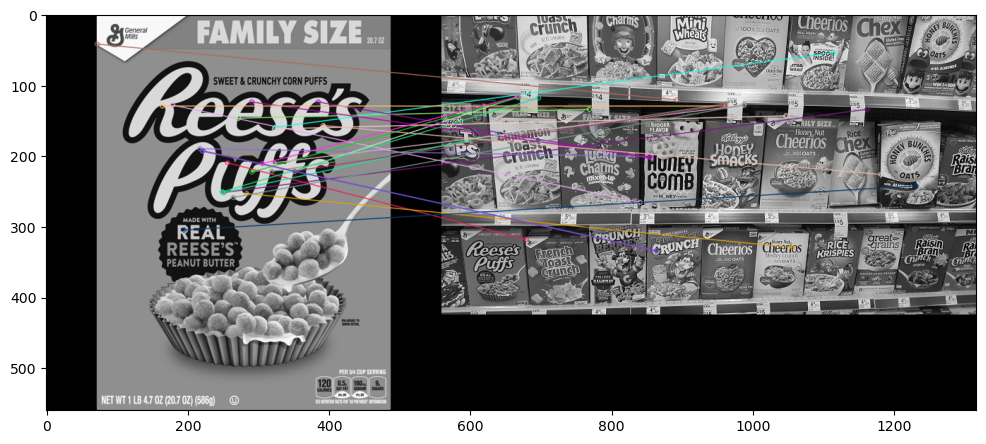

In [5]:
cereal = cv2.imread("DATA/reeses_puffs.png", 0)
many_cereal = cv2.imread("DATA/many_cereals.jpg", 0)

def display(img, cmap="gray"):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap="gray")

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(cereal, None) # None is mask
kp2, des2 = orb.detectAndCompute(many_cereal, None)

# brute force matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
matches = bf.match(des1, des2) # match descriptors

# each element in matches is a DMatch object
# the likely the match, the smaller the distance
# hence, so we sort by distance

matches = sorted(matches, key=lambda x: x.distance) # sort matches by distance

# draw the first 25 matches - provide keypoints and matches
cereal_matches = cv2.drawMatches(cereal, kp1, many_cereal, kp2, matches[:25], None, flags=2)

display(cereal_matches) # we can observe that brute force is not very good